# Finding Best LightGBM Regressor for Store Item Demand Forecasting

## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle

## Read datasets

In [3]:
# google colab
from google.colab import drive
drive.mount('/content/drive')

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/train.csv', parse_dates = ['date'])
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/test.csv', parse_dates = ['date'])

Mounted at /content/drive


In [4]:
# # jupyter
# train_data = pd.read_csv('train.csv', parse_dates = ['date'])
# test_data = pd.read_csv('test.csv', parse_dates = ['date'])

In [ ]:
train_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
test_data.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
data = pd.concat([train_data, test_data],sort= False)

data

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


## Data preprocessing

### Feature Engineering

#### Datetime features

In [9]:
def create_date_time_features(df):
    df = df.copy()

    df['day_of_week'] = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['week_of_year'] = df.date.dt.isocalendar().week.astype("int64")

    return df

In [10]:
df1 = create_date_time_features(data)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year
0,2013-01-01,1,1,13.0,NaN,1,1,1,1
1,2013-01-02,1,1,11.0,NaN,2,1,1,1
2,2013-01-03,1,1,14.0,NaN,3,1,1,1
3,2013-01-04,1,1,13.0,NaN,4,1,1,1
4,2013-01-05,1,1,10.0,NaN,5,1,1,1


#### Lag features

In [11]:
def lag_features(df, lags):
    for lag in lags:
        df['sales_lag_' + str(lag)] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return df

In [12]:
df1 = lag_features(df1, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Rolling mean features

In [13]:
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store", "item"])['sales']. \
                                             transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())
    return df

In [14]:
df1= roll_mean_features(df1, [365, 546])

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exponentially weighted mean features

In [15]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [16]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags   = [91, 98, 105, 112, 182, 273, 364, 546, 728]

In [17]:
df1= ewm_features(df1, alphas, lags)

df1.head()

,date,store,item,sales,id,day_of_week,quarter,month,week_of_year,sales_lag_91,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_273,sales_ewm_alpha_05_lag_364,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,2,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,3,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,4,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,5,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Summary

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 66 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   store                        958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   id                           45000 non-null   float64       
 5   month                        958000 non-null  int64         
 6   week_of_year                 958000 non-null  int64         
 7   day_of_week                  958000 non-null  int64         
 8   quarter                      958000 non-null  int64         
 9   sales_lag_91                 912500 non-null  float64       
 10  sales_lag_98                 909000 non-null  float64       
 11  sales_lag_105              

### One-Hot encoding

In [18]:
df2 = pd.get_dummies(df1, columns=['store', 'item', 'month', 'week_of_year' , 'day_of_week', "quarter"])

df2.shape

(958000, 196)

### Logarithmic transformation for sales data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d14a34d50>]],
      dtype=object)

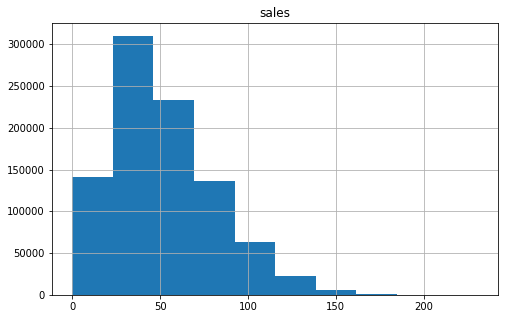

In [19]:
# original
df2.hist('sales',figsize=(8,5))

In [20]:
df2['sales']= np.log1p(df2["sales"].values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d14a85e90>]],
      dtype=object)

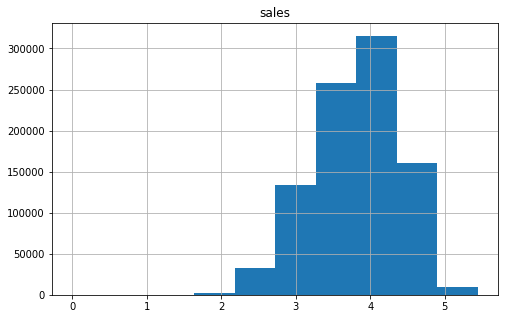

In [21]:
# transformed
df2.hist('sales',figsize=(8,5))

### Split into train val test

* train: 2013 to 2016 (4 years) - 80%
* val: 2017 (1 year) - 20%
* test: 2018 onwards

In [22]:
df_model= df2.copy()

In [23]:
df_model = df_model.sort_values("date").reset_index(drop = True)

In [24]:
train = df_model.loc[(df_model["date"] < "2017-01-01"), :]

val = df_model.loc[(df_model["date"] >= "2017-01-01") & (df_model["date"] < "2017-04-01"), :]

In [25]:
train.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
0,2013-01-01,2.639057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
1,2013-01-01,2.833213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
2,2013-01-01,3.044522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
3,2013-01-01,3.555348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0
4,2013-01-01,2.995732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,1,0,0,0


In [26]:
val.head()

,date,sales,id,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,quarter_1,quarter_2,quarter_3,quarter_4
730500,2017-01-01,3.663562,NaN,49.0,59.0,43.0,50.0,45.0,62.0,78.0,...,0,0,0,0,0,1,1,0,0,0
730501,2017-01-01,4.682131,NaN,131.0,167.0,142.0,145.0,159.0,171.0,189.0,...,0,0,0,0,0,1,1,0,0,0
730502,2017-01-01,4.077537,NaN,69.0,84.0,92.0,86.0,109.0,90.0,110.0,...,0,0,0,0,0,1,1,0,0,0
730503,2017-01-01,3.295837,NaN,40.0,34.0,33.0,33.0,34.0,44.0,39.0,...,0,0,0,0,0,1,1,0,0,0
730504,2017-01-01,3.367296,NaN,38.0,37.0,55.0,42.0,41.0,52.0,43.0,...,0,0,0,0,0,1,1,0,0,0


In [29]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]

In [30]:
X_train = train[cols]
Y_train = train['sales']

X_train.shape, Y_train.shape

((730500, 193), (730500,))

In [31]:
X_val = val[cols]
Y_val = val['sales']

X_val.shape, Y_val.shape

((45000, 193), (45000,))

## Hyperparameter tuning LightGBM regressor

In [ ]:
model = lgb.LGBMRegressor()

In [ ]:
# google colab
params = {}

params['n_estimators'] = [50, 100, 500]
params['learning_rate'] = [0.001, 0.01, 0.1]
params['subsample'] = [0.5, 0.6, 0.8]
params['max_depth'] = [3, 4, 5]

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=3, scoring='r2', verbose =50)
grid_results = grid.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_val, Y_val)])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 18.9min
[Paralle

[67]	valid_0's l2: 0.0335065
[68]	valid_0's l2: 0.0334302
[69]	valid_0's l2: 0.03341
[70]	valid_0's l2: 0.0333892
[71]	valid_0's l2: 0.0333694
[72]	valid_0's l2: 0.033302
[73]	valid_0's l2: 0.0333023
[74]	valid_0's l2: 0.0332632
[75]	valid_0's l2: 0.0332142
[76]	valid_0's l2: 0.0331997
[77]	valid_0's l2: 0.0331979
[78]	valid_0's l2: 0.0331481
[79]	valid_0's l2: 0.0331051
[80]	valid_0's l2: 0.0329884
[81]	valid_0's l2: 0.0329876
[82]	valid_0's l2: 0.0329568
[83]	valid_0's l2: 0.0329226
[84]	valid_0's l2: 0.0328714
[85]	valid_0's l2: 0.0328597
[86]	valid_0's l2: 0.0328159
[87]	valid_0's l2: 0.0328022
[88]	valid_0's l2: 0.0327828
[89]	valid_0's l2: 0.0327579
[90]	valid_0's l2: 0.0327384
[91]	valid_0's l2: 0.0327213
[92]	valid_0's l2: 0.0327178
[93]	valid_0's l2: 0.0326651
[94]	valid_0's l2: 0.0326495
[95]	valid_0's l2: 0.0326446
[96]	valid_0's l2: 0.0325845
[97]	valid_0's l2: 0.0325493
[98]	valid_0's l2: 0.0325386
[99]	valid_0's l2: 0.0325047
[100]	valid_0's l2: 0.0323974
[101]	valid_0's 

[342]	valid_0's l2: 0.0308702
[343]	valid_0's l2: 0.0308576
[344]	valid_0's l2: 0.0308543
[345]	valid_0's l2: 0.0308654
[346]	valid_0's l2: 0.0308728
[347]	valid_0's l2: 0.03087
[348]	valid_0's l2: 0.0308615
[349]	valid_0's l2: 0.0308541
[350]	valid_0's l2: 0.0308654
[351]	valid_0's l2: 0.0308657
[352]	valid_0's l2: 0.030867
[353]	valid_0's l2: 0.030865
[354]	valid_0's l2: 0.0308519
[355]	valid_0's l2: 0.0308435
[356]	valid_0's l2: 0.0308391
[357]	valid_0's l2: 0.030844
[358]	valid_0's l2: 0.0308487
[359]	valid_0's l2: 0.0308498
[360]	valid_0's l2: 0.0308319
[361]	valid_0's l2: 0.0308359
[362]	valid_0's l2: 0.0308356
[363]	valid_0's l2: 0.0308277
[364]	valid_0's l2: 0.0308179
[365]	valid_0's l2: 0.0308106
[366]	valid_0's l2: 0.0308133
[367]	valid_0's l2: 0.0308189
[368]	valid_0's l2: 0.030817
[369]	valid_0's l2: 0.0308121
[370]	valid_0's l2: 0.0307976
[371]	valid_0's l2: 0.0307983
[372]	valid_0's l2: 0.0307977
[373]	valid_0's l2: 0.0307896
[374]	valid_0's l2: 0.0307893
[375]	valid_0's 

In [ ]:
# # jupyter
# if __name__ == '__main__':
#   params = {}

# params['n_estimators'] = [50, 100, 500]
# params['learning_rate'] = [0.001, 0.01, 0.1]
# params['subsample'] = [0.5, 0.6, 0.8]
# params['max_depth'] = [3, 4, 5]

#   grid = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1, cv=3, scoring='r2', verbose=50)
#   grid_result = grid_search.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_val, Y_val)])

### Tuner results

In [32]:
# print best score
print("Best score: %f" % (grid_result.best_score_))

Best score: 0.760739


In [33]:
# print best params
print("Best params: %s" % (grid_result.best_params_))

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}


In [ ]:
results = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

In [ ]:
results

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",0.001066,79
1,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",0.001066,79
2,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",0.001066,79
3,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",0.068474,70
4,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",0.068474,70
...,...,...,...
76,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.465741,13
77,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.465741,13
78,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.760739,1
79,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.760739,1


In [ ]:
results.to_csv('lightgbm-tune_results.csv', index=False)